# EDA
参考文档：https://www.kaggle.com/code/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5

预测个体是否会发生中风。首先，我将进行深入的EDA，这有助于我发现是否存在任何特征能够指示中风的可能性，或是无中风的迹象；之后，构建多个模型并挑选出性能最佳者。我们使用F1分数作为主要评估指标，因为我们的数据集存在不平衡问题（尽管我们也会通过SMOTE方法来解决这个问题）。

## 模型的可解释性
模型的可解释性非常重要，我们需要向非技术受众解释非常复杂的技术算法，因此，掌握任何能够帮助这一过程的工具都是至关重要的。

[Note]对于imblearn库，需要从github安装最新的fix版本：
```shell
pip install git+https://github.com/scikit-learn-contrib/imbalanced-learn.git@master
```

否则出错：
```
ImportError: cannot import name '_get_column_indices'
```

In [1]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import lime.lime_tabular
import seaborn as sns
import pandas as pd
import numpy as np
import lime
import shap

from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

/home/alex/3rd/miniconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置pandas属性，忽略类型转换的告警
pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
# missing data
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## 缺失处理
有很多方法可以处理缺失值，比如可以简单地丢弃这些记录、用平均值、中位数或者甚至是缺失值前后的记录来填充空白。

还有其他一些不常见的方法，在这里，我们将使用决策树来预测缺失的BMI值。其他值得探索的有趣方法可能包括使用KNN来填补空缺。

In [4]:
# 分析一下BMI数值的分布
df['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [5]:
# 使用决策树填充确实值
DT_bmi_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('lr', DecisionTreeRegressor(random_state=42))
])

X = df[['age', 'gender', 'bmi']].copy()
X.gender = X.gender.replace({'Male':0, 'Female':1, 'Other':-1})
X.gender = X.gender.astype('uint8')

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]),index=Missing.index)
df.loc[Missing.index, 'bmi'] = predicted_bmi

In [6]:
# 分析一下BMI数值的分布
df['bmi'].describe()

count    5110.000000
mean       28.918410
std         7.731841
min        10.300000
25%        23.700000
50%        28.300000
75%        32.900000
max        97.600000
Name: bmi, dtype: float64

In [7]:
f"Missing values: {sum(df.isnull().sum())}"

'Missing values: 0'

## 数据探索
接下来我们想探索一下这些数据，探究一下年龄是否会增加中风的风险？性别呢？还是体质指数（BMI）？这些都是可以通过数据可视化来探索和回答的问题。

首先，让我们看看数值/连续变量的分布情况。

In [8]:
variables = [variable for variable in df.columns if variable not in ['id', 'stroke']]

# 定义了一个列表，包含了三个被认为是连续型变量的列名：年龄、平均血糖水平(avg_glucose_level)、以及bmi
conts = ['age', 'avg_glucose_level', 'bmi']

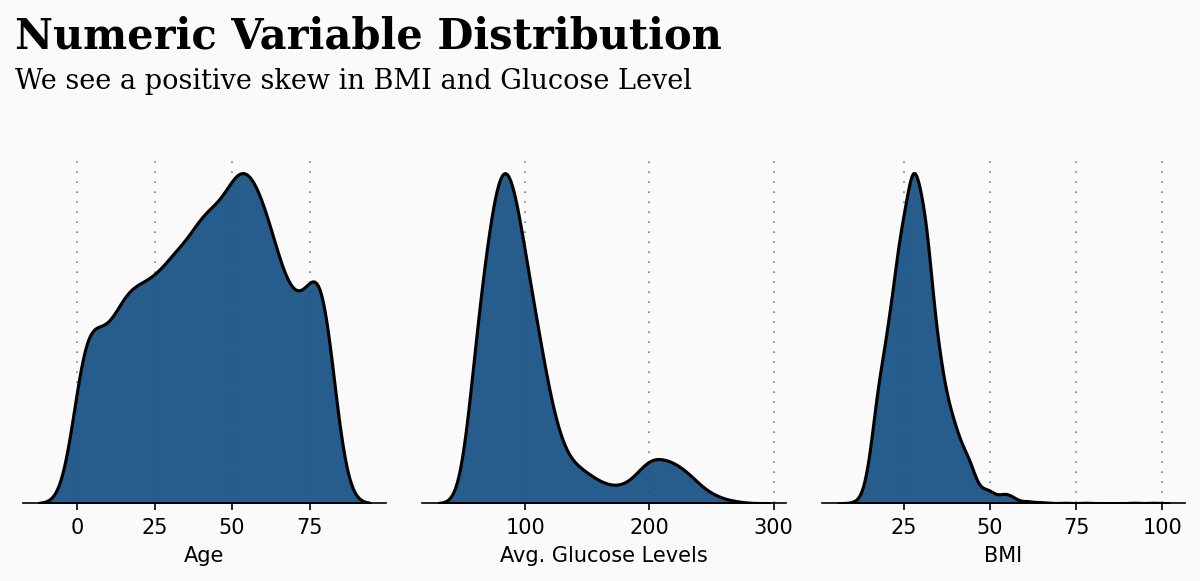

In [9]:
fig = plt.figure(figsize=(10, 3), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#fafafa"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
    sns.kdeplot(
        df[variable], ax=locals()["ax"+str(plot)], color='#0f4c81', fill=True, 
        linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False
    )
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    #locals()["ax"+str(plot)].set_xlabel(variable) removed this for aesthetics
    plot += 1
        
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')


ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

> 我们绘制了核密度估计图（Kernel Density Estimation Plot，简称KDE图），这是一种在统计学中用于估计和展示数据分布的图形方法。它提供了一种平滑的概率密度函数，用来描述一个变量的数据点在整个值域内的分布情况，类似于直方图但更加连续和平滑。
> 核心概念：
> + 核函数（Kernel Function）：核密度估计的基本思想是使用一个“核”（一个对称的、通常有界且积分总和为1的函数，如高斯分布）在每个数据点周围构建一个小的分布。然后，将这些分布在所有数据点上的贡献叠加起来，形成一个总体的概率密度估计。
> + 带宽（Bandwidth）：这是核密度估计中的一个重要参数，决定了核函数的宽度或者说每个数据点影响其邻近区域的程度。较小的带宽会导致估计更接近原始数据点，可能揭示更多的局部细节，但可能导致过拟合；较大的带宽会使估计更平滑，减少噪声影响，但可能丢失数据的一些精细结构。
> 
> 与直方图的区别：
> + 直方图是通过将数据区间分段，计算每个区间内数据点的数量来展示数据分布的，因此它的形状和精细程度取决于分段的选择。
> + 核密度估计图则是基于数据点位置，通过平滑的方法构建出连续的概率密度曲线，能够提供数据分布的更连续和平滑的视图，不受分箱影响。
> 
> 核密度估计图广泛应用于数据分析、信号处理、机器学习等领域，特别适合于探索数据的分布特性、识别模式、检测异常值以及比较不同数据集的分布差异等。通过观察KDE图，我们可以直观理解某个变量值出现的可能性或概率密度，从而对数据有一个更为深入的理解。

所以我们对数值型变量的分布有了一定的了解，接下来给这个图表添加更多信息，我们看看对于有中风和没有中风的人群，数值型变量的分布有何不同。

这一点在后续建模时可能会很重要

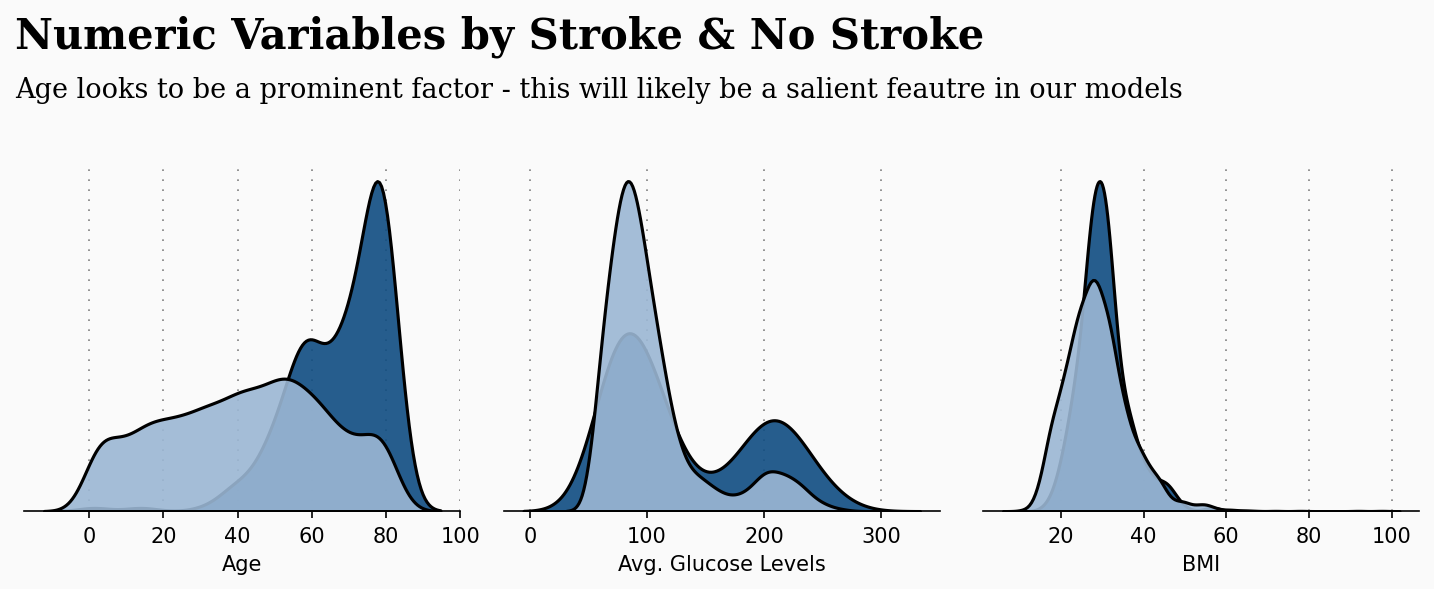

In [10]:
fig = plt.figure(figsize=(12, 3), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(
            s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', fill=True, 
            linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False
        )
        sns.kdeplot(
            ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', fill=True, 
            linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False
        )
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models', 
         fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

## 洞察
根据上述图表，很明显年龄是中风患者的一个重要影响因素——随着年龄的增长，中风的风险也在增加。虽然不那么明显，但平均血糖水平和体质指数（BMI）也存在差异。

进一步分析数据。

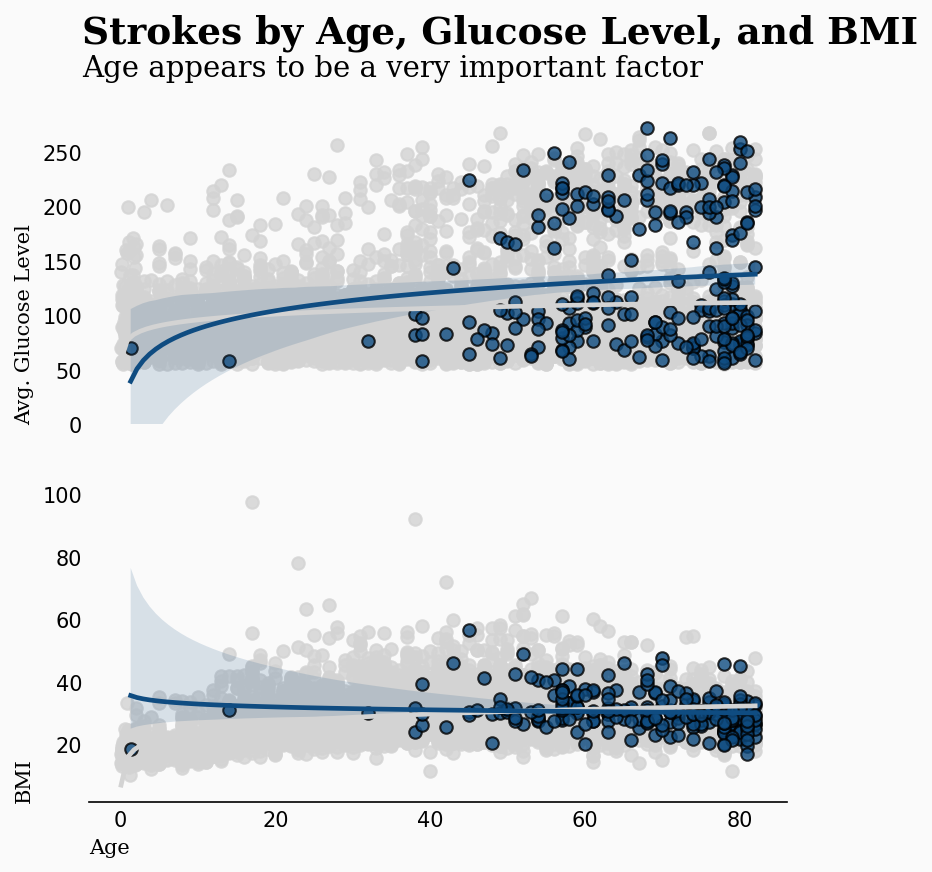

In [11]:
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

fig = plt.figure(figsize=(6,6),dpi=150,facecolor=background_color) 

gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.5, hspace=0.2)

ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2]) 

ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# glucose
sns.regplot(x=no_str_only['age'], y=no_str_only['avg_glucose_level'], color='lightgray', logx=True, ax=ax0)
sns.regplot(
    x=str_only['age'], y=str_only['avg_glucose_level'], color='#0f4c81', logx=True,
    scatter_kws={'edgecolors':['black'], 'linewidths': 1}, ax=ax0
)

ax0.set(ylim=(0, None))
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')
ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False)

for s in ['top','left','bottom']:
    ax0.spines[s].set_visible(False)

# bmi
sns.regplot(x=no_str_only['age'], y=no_str_only['bmi'], color='lightgray', logx=True, ax=ax1)
sns.regplot(
    x=str_only['age'], y=str_only['bmi'], color='#0f4c81', logx=True, ax=ax1,
    scatter_kws={'edgecolors':['black'], 'linewidths': 1}
)

ax1.set_xlabel("Age",fontsize=10,fontfamily='serif',loc='left')
ax1.set_ylabel("BMI",fontsize=10,fontfamily='serif',loc='bottom')

for s in ['top','left','right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    
ax0.text(-5,350,'Strokes by Age, Glucose Level, and BMI',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-5,320,'Age appears to be a very important factor',fontsize=14,fontfamily='serif')

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

从图中可以得出以下结论：
+ 年龄与中风（Stroke）的关系：中风（蓝色点）的实例在年龄较高时更为集中，这表明年龄较大的人群中，中风发生的几率较高。图中的趋势线也显示，随着年龄的增加，中风患者的平均葡萄糖水平和BMl（身体质量指数）有一定的变化趋势
+ 年龄与平均葡萄糖水平（Avg. Glucose Level）的关系：从上图可以看出，虽然所有人的平均葡萄糖水平分布较为广泛，但中风患者（蓝色点）的葡萄糖水平在年龄较高时有所增加。非中风患者（灰色点）的葡萄糖水平同样表现出随年龄增加的趋势，但整体增幅较缓

年龄与身体质量指数（BMI）的关系：
+ 从下图可以看出，随着年龄的增长，中风患者（蓝色点）的BMI并没有显著变化的趋势。
+ 非中风患者的BMI也没有显著变化，整体分布较为平稳。

视觉图像的强化：
+ 该图强调了年龄在中风发生中的重要作用。由于中风患者的数据点主要集中在高年龄段，这加强了年龄作为中风重要风险因素的观点

总体而言，图中的分析显现出年龄是预测中风的重要因素之一，并且年龄较大的中风患者在平均葡萄糖水平方面有升高趋势，但BMI并未表现出明显关系。这些发现可以为公共卫生政策和个人预防措施提供重要的参考。

正如我们所怀疑的，年龄是一个重要因素，并且与BMI（体质指数）和平均血糖水平也存在轻微的关系。我们可能直观上理解，随着年龄的增长，中风的风险也会增加，但能否通过可视化方式来展现这一关系呢？

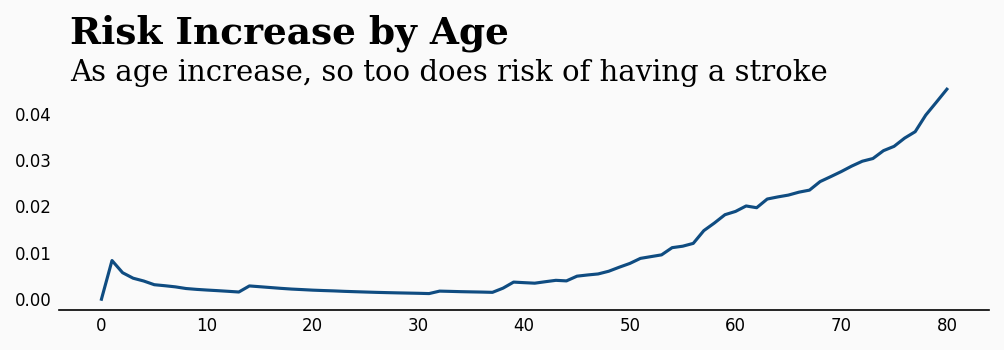

In [12]:
fig = plt.figure(figsize=(8, 5), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min()+1, df['age'].max()):
    a = df[df['age'] < i]['stroke'].sum()
    b = len(df[df['age'] < i]['stroke'])
    rate.append(a/b)

sns.lineplot(data=rate, color='#0f4c81', ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(-3,0.055,'Risk Increase by Age',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-3,0.047,'As age increase, so too does risk of having a stroke',fontsize=14,fontfamily='serif')

plt.show()

这证实了我们的直觉：年纪越大，所面临的风险就越高。然而，你可能已经注意到y轴上的风险值很低。这是因为数据集高度不平衡。在我们总数为5000条记录的数据集中，只有249例中风记录，即大约每20人中就有1例。

In [13]:
# Drop single 'Other' gender
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]
len(str_only), len(no_str_only)

(249, 4860)

In [14]:
# Drop single 'Other' gender
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]

## 总体概述
到目前为止，我们已经评估了一些变量，并获得了一些有力的见解。现在我们把数据分为“中风”和“无中风”两组，在同一个图表里绘制几个变量，以便观察这两个群体是否存在任何有意义的区别。

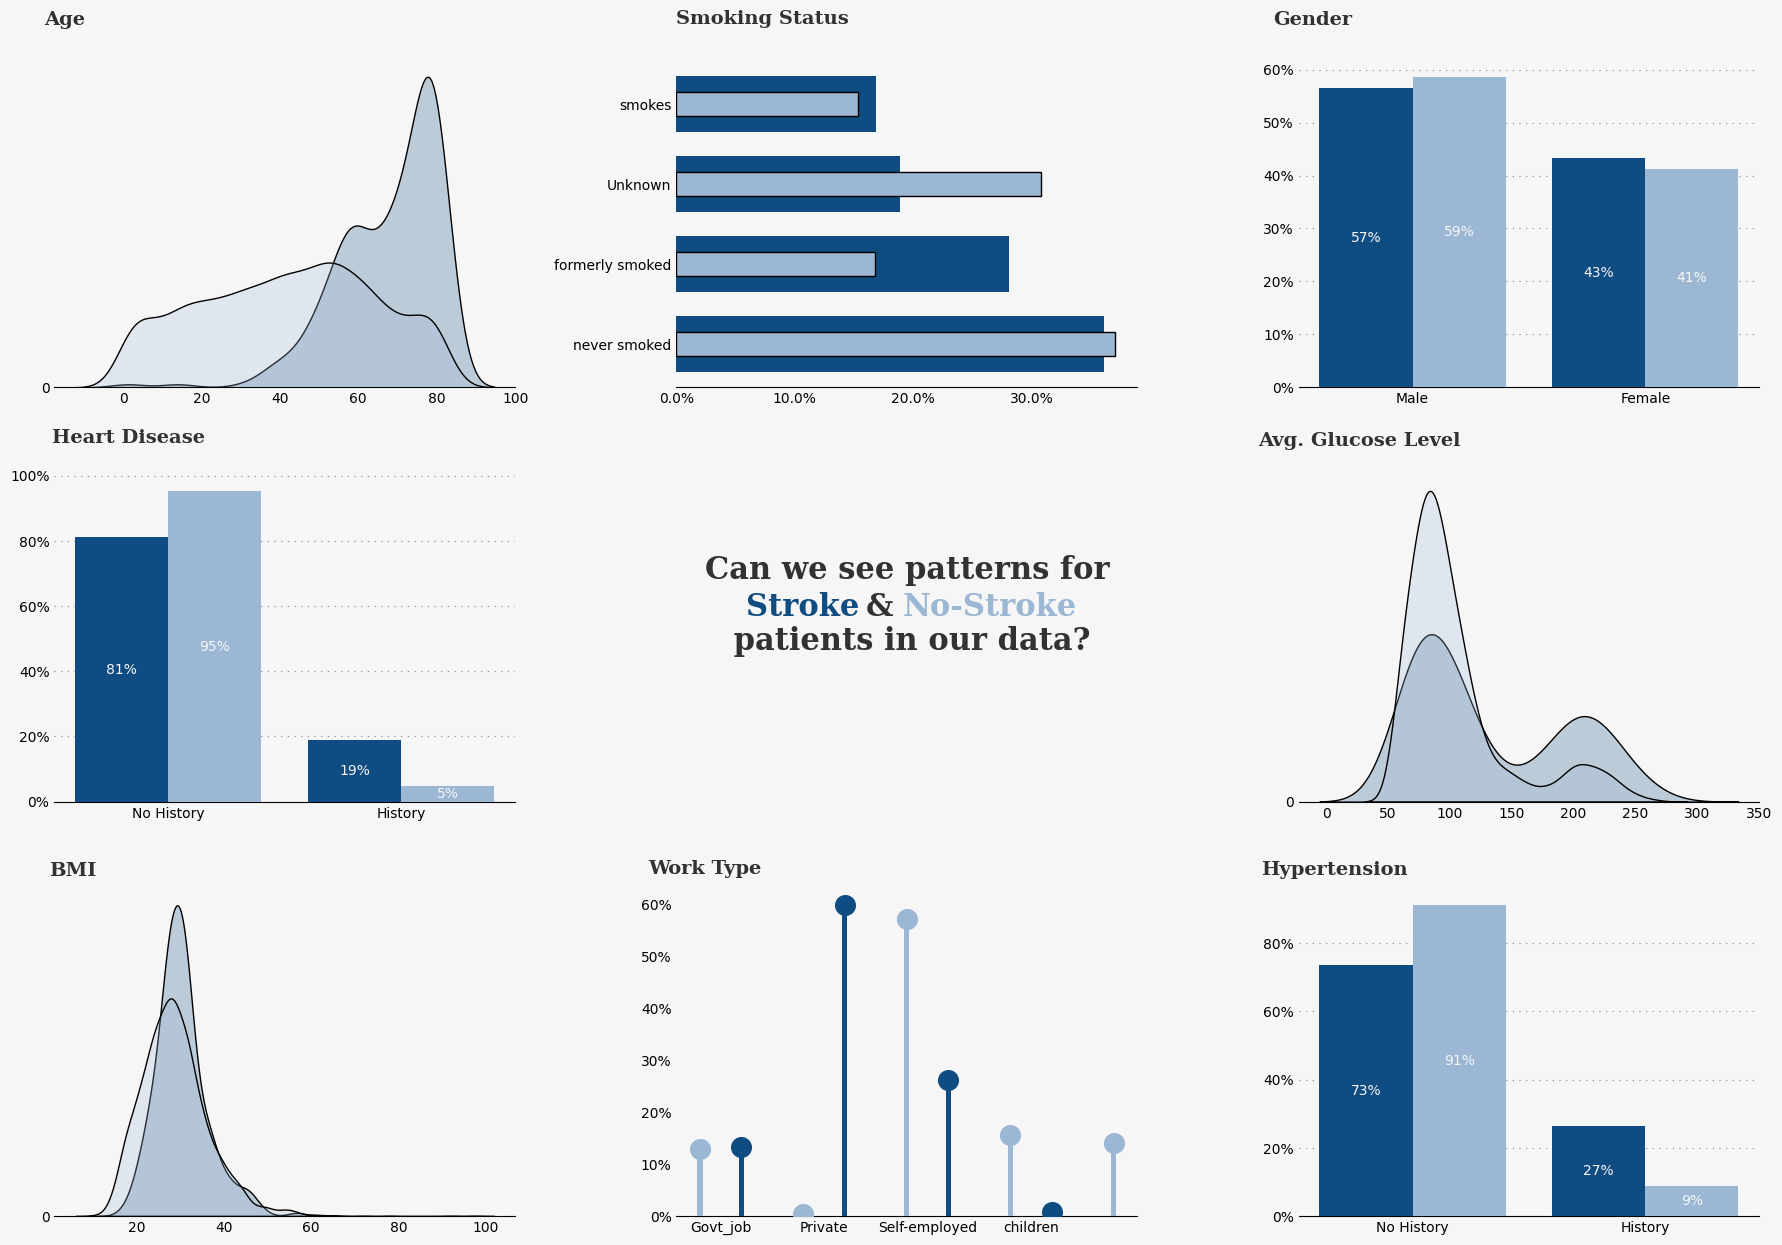

In [15]:
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color

## Age
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#0f4c81", fill=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", fill=True, ec='black',label="negative")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)
ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3, ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

# GENDER 
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)
x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

# Heart Dis
positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)
x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History','History'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

## AX4 - TITLE
ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'Can we see patterns for\n\n patients in our data?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")
ax4.text(0.15,0.57,"Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')

# Glucose
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#0f4c81",ec='black', fill=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black', fill=True, label="negative")
ax5.text(-55, 0.01855, 'Avg. Glucose Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')

## BMI
ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#0f4c81", ec='black', fill=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4",ec='black', fill=True, label="negative")
ax6.text(-0.06, 0.09, 'BMI', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')    
ax6.set_xlabel('')

# Work Type
positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
positive = positive.sort_index()
negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)
negative = negative.sort_index()
ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#9bb7d4")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#0f4c81")
ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# hypertension
positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["count"].apply(lambda x: x/sum(positive["count"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["count"].apply(lambda x: x/sum(negative["count"])*100)
x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History','History'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

# tidy up
for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

plt.show()

# Modelling

## Model preparation

In [16]:
# Encoding categorical values
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

### 不平衡的数据集
如我之前所述，当前数据中没有中风的实例（负样本）远多于有中风的实例，这种情况可能阻碍我们模型的学习性能。我们可以通过应用SMOTE方法来平衡我们的数据集。

### 基线 
针对这种不平衡的数据集，一个有用的基线目标是超越“空模型准确率”（Null Accuracy），在我们的情况下，因为我们在寻找的是正面结果（即‘中风’病例），所以我将取其相反数。换句话说，总是预测最常见的情况作为结果。在这种情况下，中风病例数249除以总样本数（中风+未中风）249+4861等于0.048。因此，一个好的目标是超越这个比例，即对于中风患者的召回率达到约5%或更高。

In [17]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',249/(249+4861))
print('Null Accuracy: ',4861/(4861+249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [18]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'work_type', 'avg_glucose_level', 'bmi']]
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [19]:
X_test.head(2)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31,0,0,1,64.85,23.0
4478,0,40,0,0,1,65.29,28.3


In [20]:
# Our data is biased, we can fix this with SMOTE
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train)
(X_train.shape, X_train_resh.shape), (y_train_resh.shape, y_train.shape)

(((1533, 7), (2914, 7)), ((2914,), (1533,)))

In [21]:
# Our data is now equal
y_train_resh.value_counts()

stroke
0    1457
1    1457
Name: count, dtype: int64

### 模型
对于这个分类任务，我们将构建随机森林、支持向量机（SVM）和逻辑回归模型，并采用10折交叉验证的方法来评估模型性能。

In [22]:
rf_pipeline = Pipeline(steps = [('scale', StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale', StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale', StandardScaler()),('LR',LogisticRegression(random_state=42))])

In [23]:
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [24]:
print('Mean f1 scores:')
print('Random Forest mean :', cross_val_score(rf_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())
print('SVM mean :', cross_val_score(svm_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())
print('Logistic Regression mean :', cross_val_score(logreg_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9305426690337967
SVM mean : 0.8770941684029632
Logistic Regression mean : 0.8284474251160271


### 随机森林
随机森林表现最佳，现在让我们尝试用它来处理未见过的负面数据。

In [25]:
rf_pipeline.fit(X_train_resh,y_train_resh)
svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

rf_pred = rf_pipeline.predict(X_test)
svm_pred = svm_pipeline.predict(X_test)
logreg_pred = logreg_pipeline.predict(X_test)

rf_cm = confusion_matrix(y_test,rf_pred )
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm = confusion_matrix(y_test,logreg_pred )

rf_f1 = f1_score(y_test,rf_pred)
svm_f1 = f1_score(y_test,svm_pred)
logreg_f1 = f1_score(y_test,logreg_pred)

In [26]:
print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean f1 scores:
RF mean : 0.16122840690978887
SVM mean : 0.15463917525773196
LR mean : 0.19462465245597776


              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.12      0.24      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8778305842885099


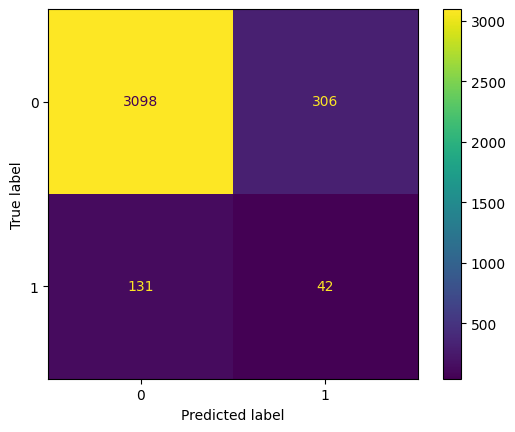

In [27]:
print(classification_report(y_test, rf_pred))
# 计算并打印准确度
print('Accuracy Score: ', accuracy_score(y_test, rf_pred))
# 生成混淆矩阵
cm = confusion_matrix(y_test, rf_pred)
# 使用 ConfusionMatrixDisplay 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# 显示图像
plt.show()

看起来准确率较高，低召回率较低，我们尝试使用网格搜索来寻找随机森林的最佳参数。

In [28]:
n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]
param_grid = {'n_estimators':n_estimators, 'max_features':max_features, 'bootstrap':bootstrap}

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)
grid.fit(X_train,y_train)
grid.best_params_

{'bootstrap': True, 'max_features': 5, 'n_estimators': 100}

In [29]:
# Let's use those params now
rfc = RandomForestClassifier(max_features=2, n_estimators=100, bootstrap=True)
rfc.fit(X_train_resh,y_train_resh)
rfc_tuned_pred = rfc.predict(X_test)

In [30]:
print(classification_report(y_test,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.11      0.22      0.15       173

    accuracy                           0.88      3577
   macro avg       0.53      0.56      0.54      3577
weighted avg       0.92      0.88      0.89      3577

Accuracy Score:  0.8755940732457367
F1 Score:  0.14587332053742802


### 逻辑回归
逻辑回归在上述指标中拥有最高的F1分数，因此或许我们可以通过调优来获得更好的结果。

In [31]:
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = [
    {'penalty': ['l1'], 'C': C, 'solver': ['liblinear']},
    {'penalty': ['l2'], 'C': C, 'solver': ['lbfgs', 'liblinear']},
    {'C': C, 'solver': ['lbfgs', 'liblinear']}
]

logreg = LogisticRegression(max_iter=500)
grid = GridSearchCV(logreg, log_param_grid)

grid.fit(X_train_resh,y_train_resh)
grid.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [32]:
# Let's use those params now
logreg_pipeline = Pipeline(
    steps = [
        ('scale',StandardScaler()),
        ('LR',LogisticRegression(C=1, penalty='l2', solver='lbfgs', random_state=42))
    ]
)

logreg_pipeline.fit(X_train_resh,y_train_resh)
logreg_tuned_pred = logreg_pipeline.predict(X_test)

In [33]:
print(classification_report(y_test,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      3404
           1       0.12      0.61      0.19       173

    accuracy                           0.76      3577
   macro avg       0.55      0.69      0.53      3577
weighted avg       0.93      0.76      0.82      3577

Accuracy Score:  0.7570589879787532
F1 Score:  0.19462465245597776


通过调整超参数，逻辑回归模型的召回分数比随机森林的好得多，即便整体准确性有所下降。

我们能够调整模型用来分类中风与非中风的阈值，让我们尝试一下...

In [34]:
for i in range(1,6):
    cm1=0
    y_pred1 = logreg_pipeline.predict_proba(X_test)[:,1]
    y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred1, threshold=i/10)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
           'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           'F1 score: ', (f1_score(y_test, y_pred2)), '\n\n',
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[1470 1934]
 [  11  162]] 

 with 1632 correct predictions,  

 1934 Type I errors( False Positives),  

 11 Type II errors( False Negatives),  

 Accuracy score:  0.4562482527257478 

 F1 score:  0.14279418245923314 

 Sensitivity:  0.9364161849710982 

 Specificity:  0.4318448883666275 



With 0.2 threshold the Confusion Matrix is  

 [[1882 1522]
 [  20  153]] 

 with 2035 correct predictions,  

 1522 Type I errors( False Positives),  

 20 Type II errors( False Negatives),  

 Accuracy score:  0.5689124965054515 

 F1 score:  0.16558441558441558 

 Sensitivity:  0.884393063583815 

 Specificity:  0.5528789659224442 



With 0.3 threshold the Confusion Matrix is  

 [[2167 1237]
 [  35  138]] 

 with 2305 correct predictions,  

 1237 Type I errors( False Positives),  

 35 Type II errors( False Negatives),  

 Accuracy score:  0.6443947441990495 

 F1 score:  0.17829457364341086 

 Sensitivity:  0.7976878612716763 

 Specificity:  0

由此可见，通过调整阈值，我们可以发现更多的中风病例。

然而，使用这种方法需谨慎。我们完全可以将阈值设定为预测每个病人都会发生中风，从而避免漏诊任何一例，但这对实际诊断并无帮助。关键在于找到“命中”与“遗漏”之间的平衡。F1分数是一个不错的起点，因为它综合考虑了多项指标的加权平均。

下面的图表展示了我所表达的意思。

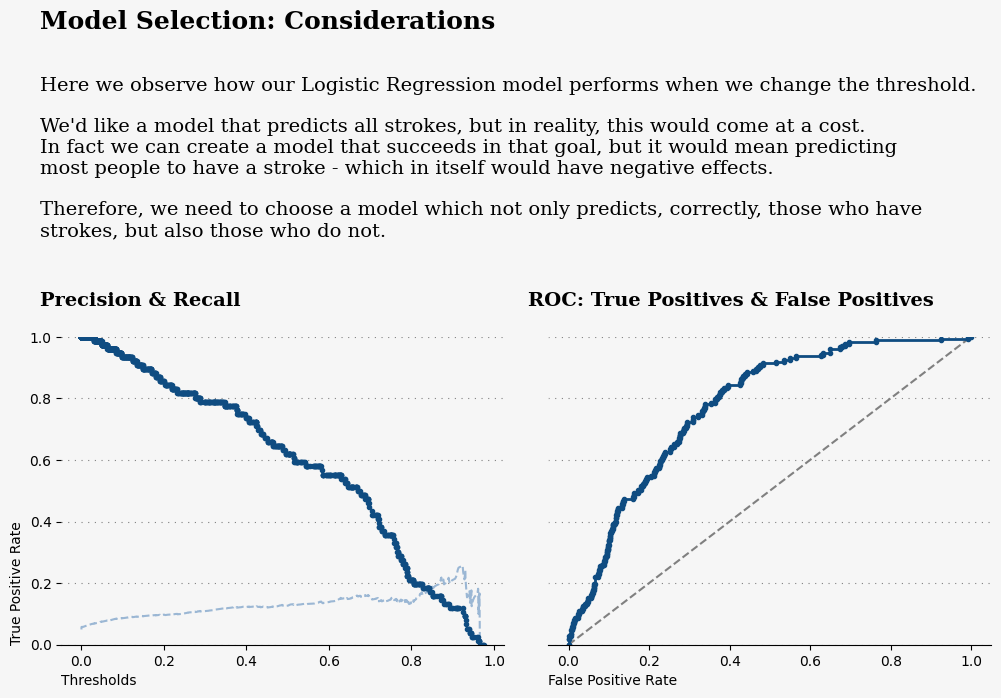

In [35]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg_pipeline.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

y_scores = logreg_pipeline.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# Plots
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, wspace=0.1,hspace=0)
ax = gs.subplots()

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)
ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))

y_scores = logreg_pipeline.predict_proba(X_train)[:,1]


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

ax[0].plot(thresholds, precisions[:-1], '--', label='Precision',color='#9bb7d4')
ax[0].plot(thresholds, recalls[:-1], '.', linewidth=1,label='Recall',color='#0f4c81')
ax[0].set_ylabel('True Positive Rate',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])

# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer',color='gray')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,color='#0f4c81')
ax[1].set_xlabel('False Positive Rate',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
    
ax[0].text(-0.1,2,'Model Selection: Considerations',fontsize=18,fontfamily='serif',fontweight='bold')
ax[0].text(-0.1,1.26,
'''
Here we observe how our Logistic Regression model performs when we change the threshold.

We'd like a model that predicts all strokes, but in reality, this would come at a cost.
In fact we can create a model that succeeds in that goal, but it would mean predicting
most people to have a stroke - which in itself would have negative effects.

Therefore, we need to choose a model which not only predicts, correctly, those who have
strokes, but also those who do not.
''',fontsize=14,fontfamily='serif')

ax[0].text(-0.1,1.1,'Precision & Recall',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].text(-0.1,1.1,'ROC: True Positives & False Positives',fontsize=14,fontfamily='serif',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)

plt.show()

### SVM
出于完整性考虑，我们再优化一下SVM模型：

In [36]:
# defining parameter range 
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} 
svm = SVC(random_state=42)
grid = GridSearchCV(svm,svm_param_grid)
grid.fit(X_train_resh,y_train_resh)
grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [37]:
svm_pipeline = Pipeline(
    steps = [
        ('scale',StandardScaler()),
        ('SVM',SVC(C=1000, gamma=0.01, kernel='rbf',random_state=42))
    ]
)

svm_pipeline.fit(X_train_resh,y_train_resh)
svm_tuned_pred = svm_pipeline.predict(X_test)

print(classification_report(y_test,svm_tuned_pred))
print('Accuracy Score: ',accuracy_score(y_test,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      3404
           1       0.09      0.45      0.15       173

    accuracy                           0.76      3577
   macro avg       0.53      0.61      0.51      3577
weighted avg       0.92      0.76      0.83      3577

Accuracy Score:  0.7626502655856864
F1 Score:  0.1535393818544367


## 选择模型
经过调优的随机森林模型为我们提供了大约94%的高准确率，但对中风患者的召回率仅为2%。而原始模型的准确率为88%，对中风患者的召回率却达到了24%。这时候，领域知识往往就显得尤为重要。在我看来，模型更应侧重于准确预测将会中风的人群，而非预测不会中风的人。因为漏掉一个中风病例的后果可能比误报更加严重。

### 比较各种得分

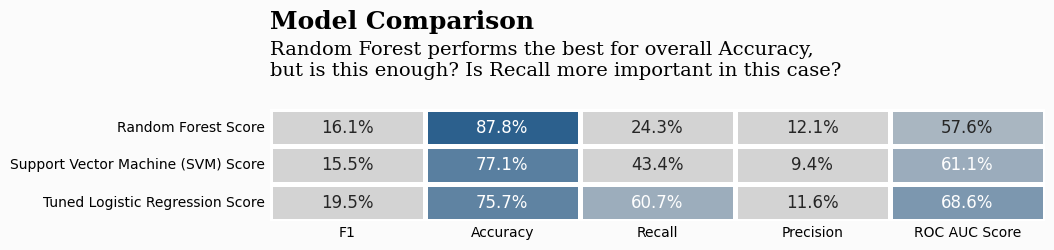

In [38]:
# Make dataframes to plot
rf_df = pd.DataFrame(
    data=[
        f1_score(y_test,rf_pred),
        accuracy_score(y_test, rf_pred), 
        recall_score(y_test, rf_pred), 
        precision_score(y_test, rf_pred), 
        roc_auc_score(y_test, rf_pred)
    ],
    columns=['Random Forest Score'],
    index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"]
)

svm_df = pd.DataFrame(
    data=[
        f1_score(y_test,svm_pred),
        accuracy_score(y_test, svm_pred), 
        recall_score(y_test, svm_pred),
        precision_score(y_test, svm_pred), 
        roc_auc_score(y_test, svm_pred)
    ], 
    columns=['Support Vector Machine (SVM) Score'],
    index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"]
)

lr_df = pd.DataFrame(
    data=[
        f1_score(y_test,logreg_tuned_pred),
        accuracy_score(y_test, logreg_tuned_pred), 
        recall_score(y_test, logreg_tuned_pred),
        precision_score(y_test, logreg_tuned_pred), 
        roc_auc_score(y_test, logreg_tuned_pred)
    ], 
    columns=['Tuned Logistic Regression Score'],
    index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"]
)

df_models = round(pd.concat([rf_df,svm_df,lr_df], axis=1),3)
colors = ["lightgray","lightgray","#0f4c81"]
colormap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-2.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

### 混淆矩阵

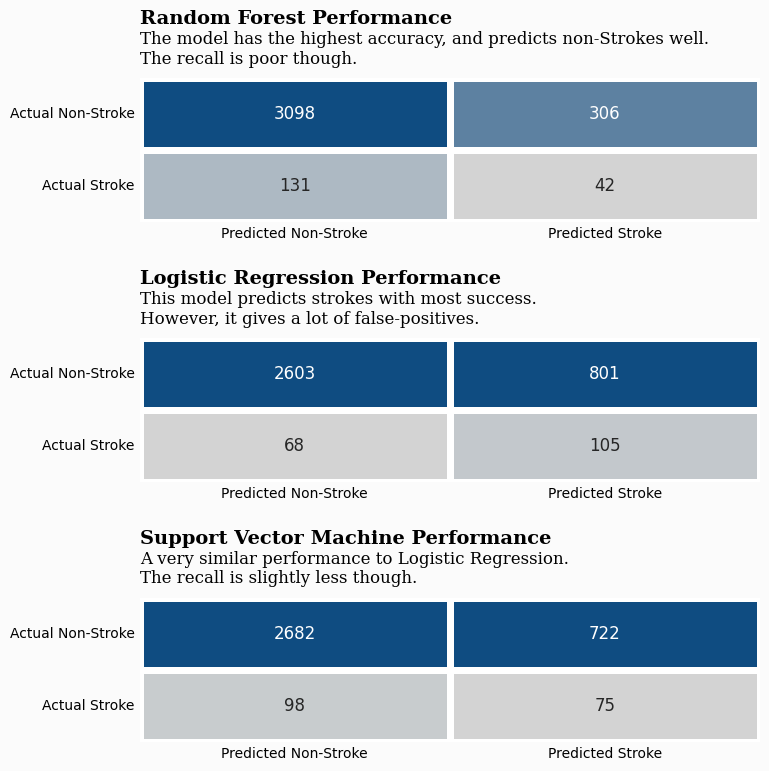

In [39]:
# Plotting our results
colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
colormap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(8,12)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color) 
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)

ax0.text(0,-0.75,'Random Forest Performance',fontsize=14,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.2,'The model has the highest accuracy, and predicts non-Strokes well.\nThe recall is poor though.',fontsize=12,fontfamily='serif')
ax1.text(0,-0.75,'Logistic Regression Performance',fontsize=14,fontweight='bold',fontfamily='serif')
ax1.text(0,-0.2,'This model predicts strokes with most success.\nHowever, it gives a lot of false-positives.',fontsize=12,fontfamily='serif')
ax2.text(0,-0.75,'Support Vector Machine Performance',fontsize=14,fontweight='bold',fontfamily='serif')
ax2.text(0,-0.2,'A very similar performance to Logistic Regression.\nThe recall is slightly less though.',fontsize=12,fontfamily='serif')

plt.show()

### 结论
所有模型的准确率都相当高，最高达到了95%（经过调优的随机森林）。但针对中风的召回率普遍较低。结果总是需要仔细考量——问问自己：“为什么需要预测这个值？”

在我们的案例中，假设预测的目的是为了向预测将会中风的人提供医疗建议或预防性治疗，因此，在实际应用中，我可能会选择召回率最高的模型。这些模型可以被认为是成功的——也就是说，有了这个模型，医疗专业人员将比没有它时装备更佳。鉴于随机森林的确拥有最高的准确率，我将进一步深入探讨该模型的工作原理，包括特征重要性分析及LIME方法的应用。

然而，由于召回率变化较大，实际模型的选择仍值得讨论和权衡。

# 归因分析
## 随机森林的特征权重
鉴于随机森林模型在‘准确率’方面表现最高（尽管这不是本项目最理想的评价指标），我认为应当包含更多分析内容，以便我们深入了解随机森林是如何做出预测的。

In [40]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = rf_feat_importance(rf_pipeline['RF'], X)
fi[:10].style.background_gradient(cmap=colormap)

,Feature,Importance
1,age,0.408708
6,bmi,0.211908
5,avg_glucose_level,0.197571
4,work_type,0.085497
0,gender,0.063958
2,hypertension,0.019501
3,heart_disease,0.012859


/tmp/ipykernel_2061127/1384968187.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)
/tmp/ipykernel_2061127/1384968187.py:9: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)


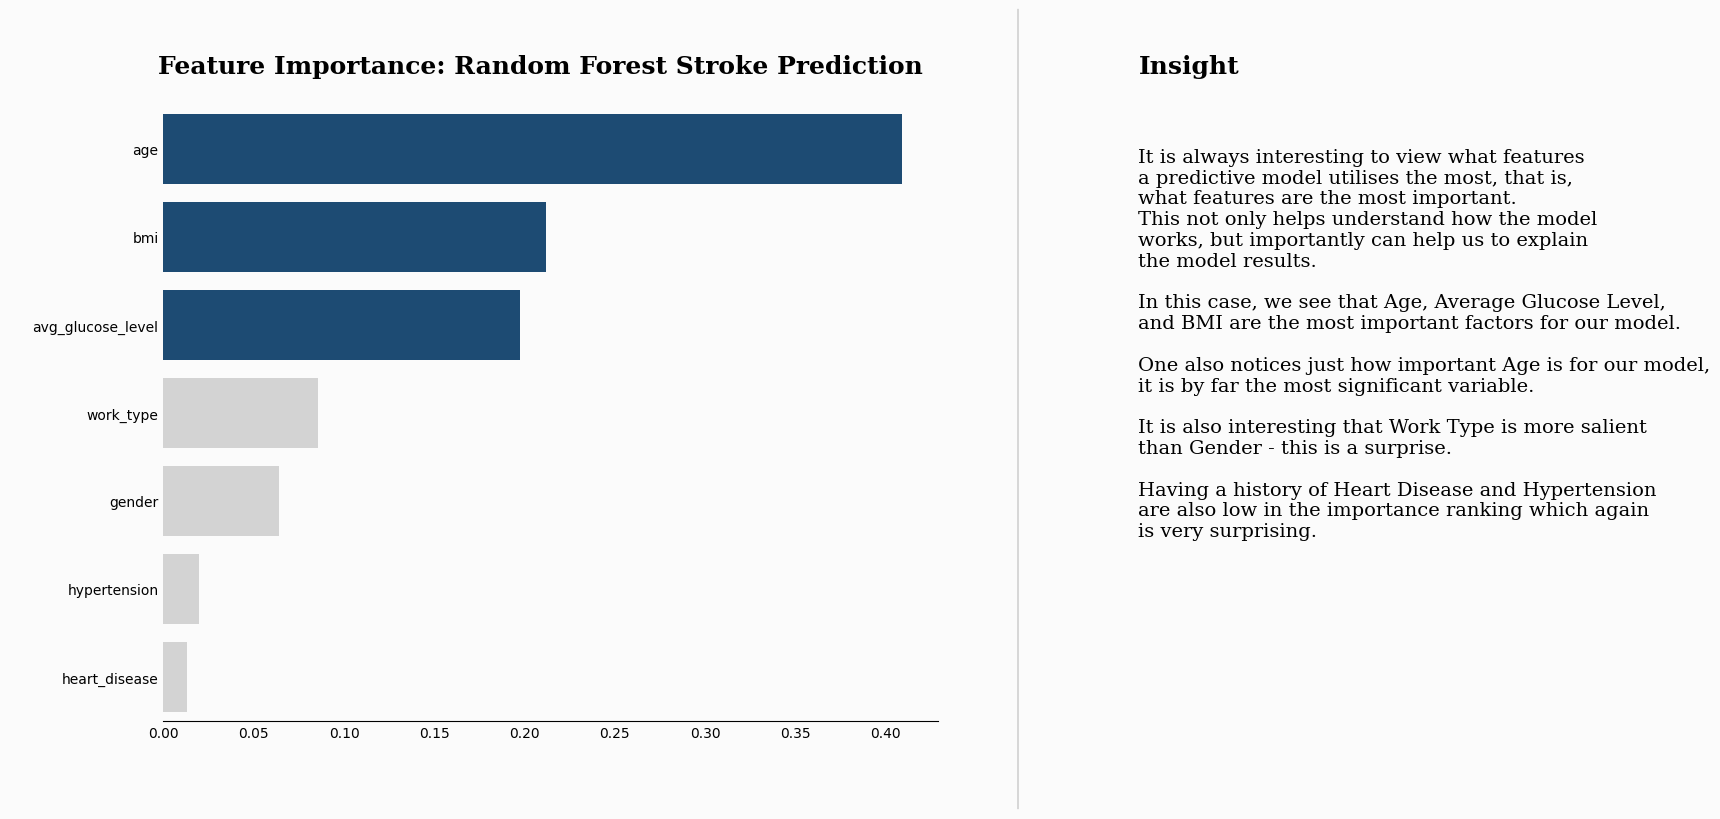

In [41]:
# let's plot this with the top 3 features highlighted
background_color = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['lightgray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0f4c81' # color highlight

sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Feature Importance: Random Forest Stroke Prediction", fontsize=18, fontweight='bold', fontfamily='serif')

plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 0.92, 'Insight', fontsize=18, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.315, '''
It is always interesting to view what features
a predictive model utilises the most, that is, 
what features are the most important. 
This not only helps understand how the model
works, but importantly can help us to explain
the model results.

In this case, we see that Age, Average Glucose Level,
and BMI are the most important factors for our model.

One also notices just how important Age is for our model,
it is by far the most significant variable.

It is also interesting that Work Type is more salient
than Gender - this is a surprise.

Having a history of Heart Disease and Hypertension
are also low in the importance ranking which again
is very surprising.
'''
, fontsize=14, fontweight='light', fontfamily='serif')

ax.tick_params(axis=u'both', which=u'both',length=0)

l1 = mpl.lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.show()

## SHAP
我们还可以使用SHAP。SHAP值（SHapley Additive exPlanations）可以分解预测结果，展示每个特征的影响。它解释了具有特定特征值相对于该特征取某个基线值（如零）时预测的影响。在此情况下，我将它应用于随机森林模型。虽然SHAP可以用于任何类型的模型，但对于基于树的模型来说，它的运行速度远超其他。此外，SHAP图中的颜色值也是可以调整的。

In [ ]:
explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)

colors = ["#9bb7d4", "#0f4c81"]           
cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[:,:,-1], X_test, cmap=cmap, alpha=0.4)

你生成的 SHAP summary plot 是用于解释模型的输出结果。下面是对图中内容的解释：

##### SHAP Summary Plot 解释
1. **横轴 (X-axis)**：
   - 横轴表示 SHAP 值，即每个特征对模型输出的影响程度。值越大（正数或负数），表示该特征对预测结果的影响越大。
   - 负值表示特征对降低模型预测值有贡献；正值表示特征对提高模型预测值有贡献。

2. **纵轴 (Y-axis)**：
   - 纵轴显示了特征名称。每一行代表一个特征。
   - 特征按重要性排序，最重要的特征在顶端，重要性依次递减。

3. **点的颜色**：
   - 颜色反映了特征的取值大小。
   - 颜色越深（例如深蓝色），表示特征值较高；颜色越浅（例如浅蓝色），表示特征值较低。

4. **点的分布**：
   - 每个点代表一个数据样本。
   - 点的分布显示了特征值如何影响 SHAP 值。
   - 点的疏密分布可以反映不同特征值的分布情况，以及它们的多寡。

##### 图中各部分的具体解读
1. **年龄 (age)**:
   - 在图中，`age` 对模型输出的影响分布较广，表示年龄在预测中的重要性较高。
   - 从颜色上看，年龄较高的取值（深蓝色）对模型输出的 SHAP 值为负数，这可能意味着随着年龄增加，某个预测值（如某种风险、疾病等）的概率降低。

2. **体重指数 (bmi)**:
   - `bmi` 的影响也显著分布，同样对模型预测有重要影响。
   - 深蓝色点多分布在负向 SHAP 值，这可能意味着较高的 BMI 值对某种预测值有负向影响。

3. **平均血糖水平 (avg_glucose_level)**:
   - 该特征对 SHAP 值的影响相对较集中。
   - 较高的血糖值（深蓝色）对模型输出的 SHAP 值为正数，可能表示高血糖值增加了某种预测结果的概率。

4. **性别 (gender)**:
   - 性别特征的 SHAP 值分布较集中，但也有一定的分布范围，表示性别对预测结果有影响。
   - 不同性别的取值影响存在一定区分。

5. **工作类型 (work_type)**:
   - 工作类型同样对模型有影响，但影响相对集中。
   - 工作类型可能因为不同工作强度和生活方式的差异，影响模型预测。

6. **高血压 (hypertension)**:
   - 高血压特征值的 SHAP 值分布较集中，总体显示不均匀影响，多样本是贡献减少预测值。
   - 患有高血压的样本，SHAP 值往往偏向负值，表示对某种预测下降有贡献。

7. **心脏病 (heart_disease)**:
   - 心脏病特征影响集中且呈现一定的规律性，对于某些预测具有明显影响。
   - 从颜色分布看，可能表示患心脏病的风险对预测值有提高或其他显著的模型输出结果。

在 SHAP summary plot 中，某些特征上的点在一条直线上，而其他特征上的点分布较为分散，这是由于每个特征在模型中的不同角色和其特征值的分布所导致的。这背后涉及多种因素：
##### 1. 特征值的离散化和分布
- **离散特征**：如果特征是离散的——即它只取少数几个不同的值（例如性别、是否有高血压、是否有心脏病），那么 SHAP 值会集中在特定的几个值上，导致它们在图中看起来像是在一条直线上。
  - 示例：性别可能只有男性和女性两个值，所以性别的 SHAP 值会集中在两个点上，形成一条直线。

- **连续特征**：如果特征是连续的——即它有很多不同的取值（例如年龄、体重指数 BMI、平均血糖水平），那么 SHAP 值会根据不同的取值而产生较为分散的分布，形成较密集的点云。
  - 示例：年龄可以是从 0 到 100 的任何值，所以年龄的 SHAP 值会在图中广泛分布，而不是集中在某几个点上。

##### 2. 特征值对模型输出的影响
- **线性模型**：在简单的线性回归模型中，特征值对模型输出的影响是直接且线性的。如果一个特征值每增加一个单位，模型输出也相应地增加或减少，那么 SHAP 值的分布会形成一个线性关系。
- **非线性模型**：在非线性模型（如决策树、随机森林、神经网络）中，特征值对模型输出的影响会更加复杂，可能取决于其他特征的取值。这会导致 SHAP 值的分布比较复杂，不再呈现简单的线性关系。

##### 3. 特征之间的相互作用
- **相互作用**：某些特征可能会和其他特征有强烈的相互作用，这种情况下，单独一个特征的 SHAP 值可能不会简单地影响模型输出，而是依赖于多个特征的组合。这会导致 SHAP 值形成非线性的复杂分布。
- **独立特征**：相比之下，如果一个特征的 SHAP 值基本上是独立的、不受其他特征影响，可能会呈现更规律、分散的分布。

##### 图中具体示例
- **离散特征（如性别、是否有高血压等）**：这些特征在图中形成直线通常是因为特征值本身有限的可能取值所导致的。例如，性别只有两个可能取值，导致其 SHAP 值集中在两个点附近。
- **连续特征（如年龄、体重指数、平均血糖水平）**：这些特征的 SHAP 值分布较为分散，因为这些特征值可以在一个广泛的范围内变化，每个取值都对模型输出有不同影响，从而形成点云状分布。

例如：
- `age` 特征在图中分布较广，因为它是一个连续变量，各个取值对模型的影响不同，导致 SHAP 值的范围较广。
- `gender` 特征在图中形成直线，因为它是一个离散变量，只有两个可能取值，导致 SHAP 值集中。

综上，SHAP summary plot 中部分特征点在一条直线上，而其他特征点分散，这是数据的特征类型和特征值分布的自然结果。这些信息帮助我们更好地理解模型对不同特征的解释和依赖。

SHAP依赖关系图¶
我们还可以关注每个变量自身变化时，其影响是如何变化的。

例如，年龄。随着年龄这一变量的增加，SHAP值也随之增加，这将患者推向我们定义的1状态（即中风）。

颜色也体现了这一点——粉色/红色代表那些遭受中风的患者。

在 SHAP summary plot 中，正向影响和负向影响的主要指每个特征对模型预测值的贡献方向和大小。具体而言：
##### 1. 正向影响（Positive Impact）
- **含义**：
  - 正向影响表示特征值的增加或较高值会导致模型预测值的增加。
  - 也就是说，当该特征取值较高时，模型的输出值（例如预测的概率或数值）会相应增加。

- **在图中的体现**：
  - 横轴上的 SHAP 值为正数。
  - 点的位置在零值的右侧。
  - 例如：在分类任务中，如果某特征值在特定样本中是正向影响的，它会使这个样本更倾向于被分类为正类（例如病人更可能患有某种疾病）。

##### 2. 负向影响（Negative Impact）
- **含义**：
  - 负向影响表示特征值的增加或较高值会导致模型预测值的减少。
  - 也就是说，当该特征取值较高时，模型的输出值会相应减少。

- **在图中的体现**：
  - 横轴上的 SHAP 值为负数。
  - 点的位置在零值的左侧。
  - 例如：在分类任务中，如果某特征值在特定样本中是负向影响的，它会使这个样本更倾向于被分类为负类（例如病人更不可能患有某种疾病）。

### SHAP依赖关系图
我们还可以关注每个变量自身变化时，其影响是如何变化的。例如，年龄。随着年龄这一变量的增加，SHAP值也随之增加，这将患者推向我们定义的1状态（即中风）。颜色也体现了这一点——粉色/红色代表那些遭受中风的患者。

In [ ]:
shap.dependence_plot('age', shap_values[:, :, 1], X_test, interaction_index="age",cmap=cmap,alpha=0.4,show=False)
plt.title("Age dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Age' feature")
plt.show()

##### 解释图中内容
1. **横轴（X-axis）**：表示 `age`（年龄）特征值的取值范围。图中显示的范围是 0 到 80+，即不同年龄的样本在数据集中的分布。
2. **纵轴（Y-axis）**：表示 `age` 特征的 SHAP 值。SHAP 值越大表示该特征对模型输出的正向影响越大；SHAP 值越小表示负向影响。

3. **点的颜色和分布**：
   - 图中的每个点表示一个数据样本，其中 X 轴是该样本的年龄值，Y 轴是对应的 SHAP 值。
   - 点的颜色深浅反映了特征值的大小（在此图的设置中颜色一致，所以点的颜色没有差异）。

##### 图中的观察
1. **低年龄段的影响**：低年龄段（约 0-20 岁），SHAP 值多数为负，意味着随着年龄增加，这部分样本对模型输出（如某个风险概率或数值）的贡献是降低的。
2. **中龄段的影响**：中龄段（约 20-40 岁），SHAP 值变化较为复杂，部分样本对模型的正向影响增加，但总的来说，分布比较广泛，且仍以负向影响为主。
3. **高年龄段的影响**：进入高年龄段（约 40 岁及以上），样本的 SHAP 值逐渐增大，大部分 SHAP 值呈现正向影响。这意味着随着年龄的增加，年龄特征对某个预测结果的正向贡献变大。
4. **极高龄段的影响**：在 80 岁以上，SHAP 值继续增加，达到最高约 0.4，这表明非常高的年龄对模型预测的正向影响显著。


同样的图表，但采用了一个更有趣的变量。这里我们清楚地看到了一个转折点，即当BMI大约超过30后，中风的发生率显著提高。这就是SHAP可视化的力量所在。

In [ ]:
shap.dependence_plot('bmi', shap_values[:, :, 1], X_test, interaction_index="bmi",cmap=cmap,alpha=0.4,show=False)
plt.title("BMI dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'BMI' feature")
plt.show()

## 使用LIME归因LR模型
LIME（Local Interpretable Model-Agnostic Explanations）是一种模型无关的局部可解释方法，它可以为我们提供逻辑回归模型预测背后的解释。有时逐个拆解并专注于单一示例会非常有用，通过使用LIME，我们能够在单个预测实例的基础上，理解模型是如何基于各个特征作出决策的，从而使得模型的决策过程变得更加透明和可解释。



In [ ]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(
    X.values, feature_names=X.columns.values.tolist(),
    class_names=['stroke'], verbose=True, mode='classification'
)

In [ ]:
# Choose the jth instance and use it to predict the results for that selection
j = 1
exp = explainer.explain_instance(X.values[j], logreg_pipeline.predict_proba, num_features=5)

In [ ]:
# Show the predictions
exp.show_in_notebook(show_table=True)

##### 图的结构与内容
1. **左图：Prediction Probabilities (预测概率)**：
   - 在图的左上部分，显示了模型对该样本的预测概率。
   - `stroke`（中风）的预测概率是 **0.52**，表示模型预测该样本发生中风的概率为 52%。
   - `Other`（非中风）的预测概率是 **0.48**，表示模型预测该样本不发生中风的概率为 48%。
   - 颜色的蓝色代表 `stroke` 类别，橙色代表 `Other` 类别。

2. **中图：Feature Importance (特征重要性)**：
   - 在图的右侧部分，显示了模型在预测该样本时对不同特征的依赖程度，即特征对预测结果的贡献。
   - 图表中按贡献度排序，每个特征的颜色与预测类别关联，蓝色为正向影响，橙色为负向影响。

3. **右图：Feature Values (特征值)**：
   - 在图的左下部分，显示了该样本的实际特征取值。

### 图中的具体内容解释
- **`gender` (性别)**:
  - 性别特征的取值为 `1.00`（可能代表男性）。
  - 性别特征对模型预测 `stroke` 的贡献是正向的，贡献度约为 **0.19**。
  - 这意味着在这个局部线性模型中，性别为男性对模型预测结果有较大正向贡献，使得该样本更容易被预测为 `stroke`。

- **`hypertension` (高血压)**:
  - 高血压特征的取值为 `0.00`（没有高血压）。
  - 高血压特征对模型预测 `stroke` 的贡献是负向的，贡献度约为 **0.14**。
  - 这意味着在这个局部线性模型中，没有高血压降低了该样本被预测为 `stroke` 的可能性。

- **`heart_disease` (心脏病)**:
  - 心脏病特征的取值为 `0.00`（没有心脏病）。
  - 心脏病特征对模型预测 `stroke` 的贡献是负向的，贡献度约为 **0.12**。
  - 这意味着没有心脏病特征同样降低了该样本被预测为 `stroke` 的可能性。

- **`age` (年龄)**:
  - 年龄特征的取值为 `61.00`。
  - 年龄在45到61岁之间对模型预测 `stroke` 的贡献是负向的，贡献度约为 **0.07**。
  - 这可能是模型认为在这个年龄段的样本较少发生中风，与数据集中其他特征的相互作用导致的。

- **`avg_glucose_level` (平均血糖水平)**:
  - 平均血糖水平特征的取值为 `202.21`。
  - 平均血糖水平较高（>200）对模型预测 `stroke` 的贡献是负向的，贡献度约为 **0.04**。
  - 这意味着血糖水平处于当前样本的显著较高水平，会减少被预测为中风的概率，不过影响比其他特征略微弱。

### 总结
- 该图由 LIME 生成，用以解释局部模型的预测。
- `gender` 对于预测中风的正向贡献最大，这增强了模型对该样本预测为中风的倾向。
- `hypertension` 和 `heart_disease` 以其负向贡献作用，使得模型预测该样本不发生中风的可能性更大。
- `age` 和 `avg_glucose_level` 都有负向贡献，但较小。

这些解释使得纯粹黑箱的复杂模型变得更加透明，使得用户能更好地理解单个预测结果背后的原因。通过理解局部模型的行为，可以推断哪些特征在特定实例中的影响最大，也可以进一步优化模型，对异常结果进行深度分析。如果对解释还有其他问题，请随时提问。

## ELI5
ELI5 (Explain Like I'm 5) 是一个用于解释机器学习模型的 Python 库。它提供了多种工具，用于解释和调试黑箱模型的预测结果，使得复杂的机器学习模型更容易被理解和解释。ELI5 支持多种机器学习库和算法，如 scikit-learn、XGBoost、LightGBM、CatBoost 和 Keras。

由于ELI5和Scikit-Learn的版本问题，这个Notebook中无法演示了。

##### ELI5 的核心功能
1. **特征重要性 (Feature Importance)**：
   - 显示模型的全局特征重要性，指出哪些特征对模型的整体性能贡献最大。
   - 特征重要性可以通过多种方式计算，如权重、基于树的模型中的增益等。

2. **个体预测解释 (Individual Prediction Explanation)**：
   - 解释单个样本的预测结果，识别哪些特征对该特定预测起了关键作用。
   - 通过展示每个特征对预测分数的贡献，帮助理解模型对单个数据点的决策过程。

3. **Pandas DataFrame 支持**：
   - 直接从 Pandas DataFrame 数据中提取并显示特征重要性或预测结果解释。

4. **支持多种模型和库**：
   - 例如 scikit-learn、XGBoost、LightGBM、CatBoost、Keras 等。

5. **基于文本数据的解释**：
   - 针对文本数据的特性，ELI5 提供了特定的工具来解释文本数据的模型，如词权重、简单词袋模型等。

##### 主要工具和方法
1. **解释模型**：
   - 对整个模型进行解释，提供全局特征重要性和整体理解。
   - `eli5.show_weights(estimator)`：

    ```python
    import eli5
    from sklearn.ensemble import RandomForestClassifier

    # 示例：训练一个简单的模型
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # 展示模型的权重和特征重要性
    eli5.show_weights(model, feature_names=X_train.columns.tolist())
    ```

2. **解释单个预测**：
   - 显示一个特定样本的预测解释，识别单个特征的贡献。
   - `eli5.explain_prediction(estimator, sample)`：

    ```python
    # 解释一个单独样本的预测
    sample = X_test.iloc[0]
    eli5.show_prediction(model, sample, feature_names=X_test.columns.tolist())
    ```

3. **Permutation Importance (排列重要性)**：
   - 计算特征排列后的模型表现变化，用于评估特征重要性。
   - `eli5.sklearn.PermutationImportance`：

    ```python
    from eli5.sklearn import PermutationImportance
    
    perm = PermutationImportance(model, random_state=1).fit(X_valid, y_valid)
    eli5.show_weights(perm, feature_names=X_valid.columns.tolist())
    ```

4. **文本特征解释**：
   - 对文本数据的特征权重进行可视化（主要用于 NLP 模型）。
   - `eli5.show_prediction(classifier, doc)`：

    ```python
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression

    # 示例：文本数据
    vec = TfidfVectorizer()
    X = vec.fit_transform(docs)
    clf = LogisticRegression().fit(X, y)

    # 解释文本分类模型的单个预测
    doc = docs[0]  # 选择一个文档
    eli5.show_prediction(clf, doc, vec=vec)
    ```

### 常见应用场景
1. **模型调试**：
   - 通过 ELI5 解释模型的重要特征，识别模型存在的潜在问题。
   - 帮助模型开发者理解哪些特征对模型决策最重要，从而优化特征工程和模型选择。

2. **模型透明性**：
   - 增强模型的解释性，使业务用户和顾客能理解模型的工作原理，进一步增加对模型的信任。
   - 特别适用于在医疗、金融等需要高度模型透明性的行业。

3. **异常检测**：
   - 通过解释个体预测结果，识别模型预测中的异常现象，探究其背后的原因。
   - 帮助快速定位数据问题或模型问题，确保模型输出的可靠性。